In [104]:
import talib
candle_names = talib.get_function_groups()['Pattern Recognition']
removed = ['CDLCOUNTERATTACK', 'CDLLONGLINE', 'CDLSHORTLINE', 
           'CDLSTALLEDPATTERN', 'CDLKICKINGBYLENGTH']
candle_names = [(name.replace('CDL','')).lower() for name in candle_names if name not in removed]

In [156]:
import yfinance as yf
import numpy as np
import pandas as pd

# Define the list of stock tickers
# stock_tickers = [sym+".NS" for sym in pd.read_csv('ind_nifty100list.csv').Symbol]
# stock_tickers = ['SBIN.NS', 'TCS.NS', 'MARUTI.NS', 'HINDALCO.NS', 'INFY.NS', 'RELIANCE.NS', 'TATASTEEL.NS', 'CIPLA.NS', 'ITC.NS']
stock_tickers = ["^NSEI"]

# Define the date range
start_date = '2016-01-04'
end_date = '2022-01-02'
ed = "2021-01-31"

# Initialize lists to hold the numpy arrays for each stock
opens = []
closes = []
highs = []
volumes = []
thereshold_volume = []
patterns = []
# Loop through each ticker and download the data
for ticker in stock_tickers:
    # Download the historical data
    try:
        data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
        print(data.index[0], data.index[-1])
        


    # Check if the data covers the full date range
        if data.index[0] <= pd.to_datetime(start_date) and data.index[-1] >= pd.to_datetime(ed):
            # If the data is sufficient, append the numpy arrays
            opens.append(data['Open'].iloc[1:].values)
            closes.append(data['Adj Close'].iloc[1:].values)
            highs.append(data['High'].iloc[1:].values)
            volumes.append(data['Volume'].iloc[1:].values)
            thereshold_volume.append((data['Volume'].iloc[1:].rolling(20).mean() + data['Volume'].iloc[1:].rolling(20).std()).values)
            df = data.ta.cdl_pattern(name=candle_names)
            pat = np.sum(df.iloc[1:].values, axis=1)
            patterns.append(np.where(pat < 0, 1, 0))


        else:
            print(f"Data for {ticker} does not cover the full date range from {start_date} to {end_date}.")
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        continue
# Convert lists to 2D numpy arrays
opens = np.column_stack(opens)
closes = np.column_stack(closes)
highs = np.column_stack(highs)
volumes = np.column_stack(volumes)
thereshold_volume = np.column_stack(thereshold_volume)
patterns = np.column_stack(patterns)


[*********************100%%**********************]  1 of 1 completed

2016-01-04 00:00:00 2021-12-31 00:00:00


In [163]:
threshold_percent = 2 # 0.5%
lower_threshold_percent = 3 # 2%

# Calculate the percentage difference between the current open and the previous day's close
percent_diff = ((opens[1:] - closes[:-1]) / closes[:-1] ) *100

# Find where the current open is greater than 0.5 percent above the previous day's close
above_threshold_indices = np.where( ((volumes[:-1] > 0.7 * thereshold_volume[:-1])) )

# Count the number of times this happens
times_above_threshold = above_threshold_indices[0].size

# Calculate the percentage change between the same day's open and high for those instances
same_day_percent_change = (closes[1:][above_threshold_indices] - opens[1:][above_threshold_indices]) / opens[1:][above_threshold_indices] * 100

# Calculate the mean of these percentage changes
mean_percent_change = np.mean(same_day_percent_change)

# Count how many times the percentage change between the open and high is greater than the mean percentage change
times_above_mean = np.sum(same_day_percent_change < 1)

average_change = np.mean(same_day_percent_change)
median_change = np.median(same_day_percent_change)
max_change = np.max(same_day_percent_change)
min_change = np.min(same_day_percent_change)

times_above_median = np.sum(same_day_percent_change > median_change)
print(f"Median percent change: {median_change}%")
print(f"Maximum percent change: {max_change}%")
print(f"Minimum percent change: {min_change}%")
print(f'times_above_median = {times_above_median}')
# Print the results
print(f"Average percentage change between open and high: {average_change}")
print(f"Number of times open price was greater than {threshold_percent}% of the previous close: {times_above_threshold}")
print(f"Out of those times, the number of times the percentage change between open and high was greater than the mean: {times_above_mean}")

Median percent change: -0.06478320465052308%
Maximum percent change: 9.306520074345535%
Minimum percent change: -6.817998418966896%
times_above_median = 494
Average percentage change between open and high: -0.08398499805020877
Number of times open price was greater than 2% of the previous close: 989
Out of those times, the number of times the percentage change between open and high was greater than the mean: 916


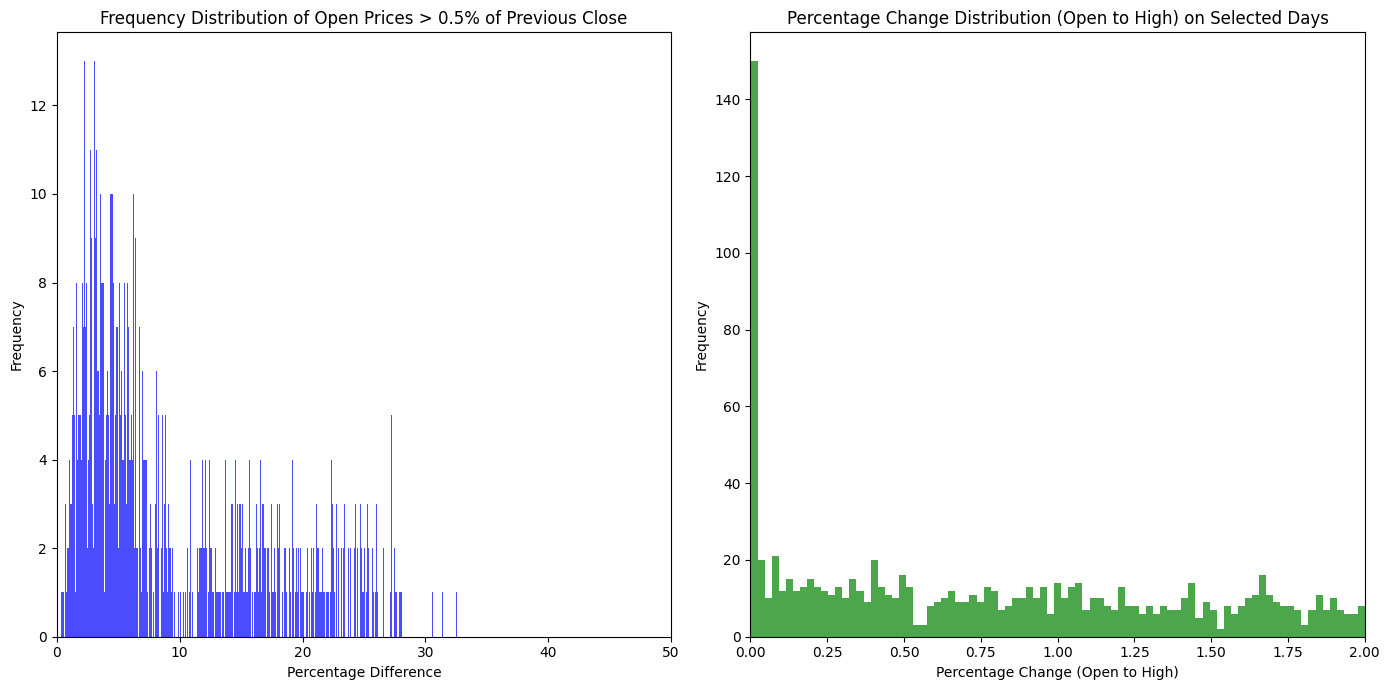

In [91]:
import numpy as np
import matplotlib.pyplot as plt
# Plot the distribution of frequency when open price was greater than 0.5% of the previous close
plt.figure(figsize=(14, 7))

# Histogram for the frequency of open prices greater than 0.5% above the previous close
plt.subplot(1, 2, 1)
plt.hist(percent_diff[above_threshold_indices], bins=1000, color='blue', alpha=0.7)
plt.title('Frequency Distribution of Open Prices > 0.5% of Previous Close')
plt.xlabel('Percentage Difference')
plt.ylabel('Frequency')
plt.xlim(0, 50)  # Limit x-axis to 10 percent

# Histogram for the percentage change between open and high on the same day
plt.subplot(1, 2, 2)
plt.hist(same_day_percent_change, bins=1000, color='green', alpha=0.7)
plt.title('Percentage Change Distribution (Open to High) on Selected Days')
plt.xlabel('Percentage Change (Open to High)')
plt.ylabel('Frequency')
plt.xlim(0, 2)  # Limit x-axis to 10 percent
# Show the plots
plt.tight_layout()
plt.show()

## only nifty 50

In [219]:
# data = yf.download("SBIN.NS", start=start_date, end=end_date, interval="1d")
data = yf.download("SBIN.NS", period='2y', interval="1d")

data= data.iloc[1:]

[*********************100%%**********************]  1 of 1 completed


In [289]:
def give_candle_info(data):
    data = data.iloc[1:]
    data['Volume_mean'] = data['Volume'].rolling(20).mean()
    data['Volume_mean'] = data['Volume_mean'].shift(1)
    data['Volume'] = data['Volume'].shift(1)
    data['Close_2'] = data['Close'].shift(1)
    df = data.ta.cdl_pattern(name=candle_names)
    df.index = data.index
    print(len(data))
    data = pd.concat([data, df ], axis=1, ignore_index=False)
    # print(len(data))
    for col in df.columns:
        data[col] = data[col].shift(1)
    mp = {}
    ## Required info 
    ## Win ratio, 1% up winn ratio, %change in volume from the 20 day mean  when change is >1 percent. 
    data= data.iloc[22:]
        ## long
    for col in df.columns: 
        filter_df = data.loc[data[col] > 0]
        if len(filter_df) > 0:
            diff = filter_df['Close'] - filter_df['Open']
            percent = diff / filter_df['Open']
            mean = np.mean(percent.values)
            win_percent = len(filter_df[diff > 0 ]) / len(filter_df) 
            greater_than_1 = len(filter_df[percent > 0.01 ]) / len(filter_df)
            vol_mean = np.mean(((filter_df['Volume'] / filter_df['Volume_mean']) -1).values)
            mp[col+"_bull"] = {'win_percent':win_percent,'mean':mean,'greater_than_1':greater_than_1,'vol_mean':vol_mean, "freq" : len(filter_df)}

        ## short
        
        filter_df = data[data[col] < 0]
        if len(filter_df) > 0:
            diff = filter_df['Close'] - filter_df['Open']
            percent = diff / filter_df['Open']
            mean = np.mean(percent.values)
            win_percent = len(filter_df[diff <0 ]) / len(filter_df)
            less_than_1 = len(filter_df[percent < -0.01 ]) / len(filter_df)
            vol_mean = np.mean(((filter_df['Volume'] / filter_df['Volume_mean']) -1).values)
            mp[col+"_bear"] = {'win_percent':win_percent,'mean':mean,'less_than_1':less_than_1,'vol_mean':vol_mean, "freq" : len(filter_df)}
    return mp
    
def print_mp(mp, filter_col, val):
    for k in mp :
            if filter_col in  mp[k] and mp[k][filter_col] > val :
                print(k, mp[k])

    

In [290]:
stock_name = "TCS.NS"
data = yf.download(stock_name, start=start_date, end=end_date, interval="1d")
mp_train = give_candle_info(data)
data = yf.download(stock_name, period='2y', interval="1d")
mp_test = give_candle_info(data)

[*********************100%%**********************]  1 of 1 completed


C:\Users\Shubham\AppData\Local\Temp\ipykernel_8956\1555190376.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Volume_mean'] = data['Volume'].rolling(20).mean()
C:\Users\Shubham\AppData\Local\Temp\ipykernel_8956\1555190376.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Volume_mean'] = data['Volume_mean'].shift(1)
C:\Users\Shubham\AppData\Local\Temp\ipykernel_8956\1555190376.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

1480


[*********************100%%**********************]  1 of 1 completed
C:\Users\Shubham\AppData\Local\Temp\ipykernel_8956\1555190376.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Volume_mean'] = data['Volume'].rolling(20).mean()
C:\Users\Shubham\AppData\Local\Temp\ipykernel_8956\1555190376.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Volume_mean'] = data['Volume_mean'].shift(1)
C:\Users\Shubham\AppData\Local\Temp\ipykernel_8956\1555190376.py:5: SettingWithCopyWarning: 
A value is tryi

494


In [292]:
print_mp(mp_train, "greater_than_1", 0.1)
print_mp(mp_train, "less_than_1", 0.1)
print("============================testing results============================")
print_mp(mp_train, "greater_than_1", 0.1)
print_mp(mp_train, "less_than_1", 0.1)

CDL_3OUTSIDE_bull {'win_percent': 0.5454545454545454, 'mean': 0.0006173960191148271, 'greater_than_1': 0.18181818181818182, 'vol_mean': 0.0447507612848384, 'freq': 22}
CDL_BELTHOLD_bull {'win_percent': 0.5203252032520326, 'mean': 0.0014987752050922547, 'greater_than_1': 0.24390243902439024, 'vol_mean': 0.14669025919468182, 'freq': 123}
CDL_CLOSINGMARUBOZU_bull {'win_percent': 0.4473684210526316, 'mean': -0.0008312225104126281, 'greater_than_1': 0.15789473684210525, 'vol_mean': -0.10928710012607559, 'freq': 38}
CDL_DOJI_10_0.1_bull {'win_percent': 0.46798029556650245, 'mean': -0.0009102375128165855, 'greater_than_1': 0.18226600985221675, 'vol_mean': -0.13598339578212315, 'freq': 203}
CDL_DOJISTAR_bull {'win_percent': 0.42857142857142855, 'mean': -0.004289479282864078, 'greater_than_1': 0.21428571428571427, 'vol_mean': 0.2017931445442514, 'freq': 14}
CDL_DRAGONFLYDOJI_bull {'win_percent': 0.3076923076923077, 'mean': -0.003972726583495233, 'greater_than_1': 0.23076923076923078, 'vol_mean'

In [281]:
print_mp(mp_train, "win_percent", 0.7)

print("============================testing results============================")
print_mp(mp_test, "win_percent", 0.6)


CDL_CLOSINGMARUBOZU_bear {'win_percent': 0.7575757575757576, 'mean': -0.0038743725730893256, 'less_than_1': 0.09090909090909091, 'vol_mean': -0.184411195452095, 'freq': 33}
CDL_DARKCLOUDCOVER_bear {'win_percent': 0.75, 'mean': -0.002343683127805509, 'less_than_1': 0.0, 'vol_mean': 0.07520219844842965, 'freq': 4}
CDL_ENGULFING_bear {'win_percent': 0.7049180327868853, 'mean': -0.0010689115677158525, 'less_than_1': 0.03278688524590164, 'vol_mean': 0.09693186196714908, 'freq': 61}
CDL_EVENINGSTAR_bear {'win_percent': 0.7333333333333333, 'mean': -0.001281174642818622, 'less_than_1': 0.0, 'vol_mean': 0.25608058027757835, 'freq': 15}
CDL_GAPSIDESIDEWHITE_bull {'win_percent': 1.0, 'mean': 1.8619355701264883e-05, 'greater_than_1': 0.0, 'vol_mean': 0.3518739534112698, 'freq': 1}
CDL_MARUBOZU_bear {'win_percent': 0.7368421052631579, 'mean': -0.005213075855403579, 'less_than_1': 0.10526315789473684, 'vol_mean': -0.19377474514829504, 'freq': 19}
CDL_ONNECK_bear {'win_percent': 1.0, 'mean': -0.00563

In [188]:
len(data)

1480

In [184]:
des.index[0]

Timestamp('2016-02-03 00:00:00')

In [185]:
day_frequencies = des.index.dayofweek.value_counts().sort_index()

# To get the day names instead of numbers
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_frequencies.index = day_frequencies.index.map(lambda x: day_names[x])

# Print the frequencies of each day
print(day_frequencies)

Date
Monday       129
Tuesday      108
Wednesday    116
Thursday     126
Friday       119
Name: count, dtype: int64


In [178]:
f

,Open,High,Low,Close,Adj Close,Volume,Volume_diff
Date,,,,,,,
2016-02-03,7392.450195,7419.399902,7350.299805,7361.799805,7361.799805,192000,244403.791438
2016-02-04,7411.450195,7457.049805,7365.950195,7404.000000,7404.000000,222700,244467.847104
2016-02-05,7418.250000,7503.149902,7406.649902,7489.100098,7489.100098,249800,245757.282363
2016-02-08,7489.700195,7512.549805,7363.200195,7387.250000,7387.250000,171500,249499.247141
2016-02-10,7264.299805,7271.850098,7177.750000,7215.700195,7215.700195,246900,249875.975550
...,...,...,...,...,...,...,...
2021-12-14,17283.199219,17376.199219,17225.800781,17324.900391,17324.900391,271000,355457.668008
2021-12-15,17323.650391,17351.199219,17192.199219,17221.400391,17221.400391,215000,355119.742313
2021-12-20,16824.250000,16840.099609,16410.199219,16614.199219,16614.199219,330600,358180.322484
